### Imports

In [44]:
from utils import *
# Total model plot
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
# Total model design
from tensorflow.keras.models import Sequential, Model, Model, save_model, load_model
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, add
# Tokenizer 
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
# Visualisation
import matplotlib.pyplot as plt

### Loading data 

In [45]:
# Location of the Flickr8k images and caption files
dataset_image_path ="flickr8k/Images/"
dataset_text_path  ="flickr8k/captions.txt" 
# Wanted shape for images
wanted_shape = (224,224,3)

In [46]:
# To obtain the text dataset corresponding to images
train, infer = False, True

if train:
    df_texts = pd.read_csv(dataset_text_path, sep=",") #["image","caption"] 
elif infer:
    df_texts = pd.read_csv("df_texts.csv", index_col=0) # ["image","caption","cleaned","cleaned_tokenized"]
    print("df_texts loaded")
    df_texts.head()

n_img = df_texts.count()/5 # 40455/5 
unique_img = pd.unique(df_texts["image"])# 8091 unique images

df_texts loaded


### Preprocessing images with pretrained VGG16 : FEATURE MAPS 4096

In [4]:
base_model = VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=wanted_shape, pooling=None, classes=1000
)
# Feature extraction
vgg_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output) #end the modèle with a 4096 feature layer

In [5]:
# To obtain the feature maps
if train :
    charge_image, one_by_one = False, False
    if charge_image:
        dimages = np.array([vgg_model.predict(load_img_from_ds(unique_img[i])) for i in range(len(unique_img))])
        print(f"Shape des fm {dimages.shape}")
    elif one_by_one:
        dimages=[]
        for i in range(len(unique_img)):
            if i!=0:
                print(f"{i}/{len(unique_img)} - time elapsed :{time.time()-a}")
            else:
                print(f"{i}/{len(unique_img)}")
            a=time.time()
            img = load_img_from_ds(unique_img[i])
            feature_map = vgg_model.predict(img)
            dimages.append(feature_map)
        dimages=np.array(dimages)
        #save to csv
        feature_maps_sav=dimages[:,0,:]
        df_fm = pd.DataFrame(feature_maps_sav)
        df_fm.to_csv("image_feature_maps.csv")
        
# To load the feature maps
elif infer:
    df_fm = pd.read_csv("image_feature_maps.csv")
    dimages = np.array(df_fm.drop([df_fm.columns[0]], axis=1))
    print(f"Image feature maps loaded : {dimages.shape}")

Image feature maps loaded : (8091, 4096)


### Preprocessing captions - WORD2VEC : EMBEDDINGS 4096

In [6]:
if train :
    # Text preprocessing
    df_texts["cleaned"]=[process_sentence(s) for s in df_texts["caption"]]
    df_texts["cleaned_tokenized"]=[word_tokenize(w) for w in df_texts["cleaned"]]

##### Tokenizer

In [48]:
if train :
    nb_words = 8747 #len(word2vec_model.wv.vocab)
    tokenizer = Tokenizer(num_words=nb_words)
    tokenizer.fit_on_texts(df_texts["cleaned_tokenized"])
    # Save tokenizer
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
elif infer :
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

vocab_size = len(tokenizer.word_index) + 1
dtexts = tokenizer.texts_to_sequences(df_texts["cleaned_tokenized"])

print(f"Vocabulary size : {vocab_size}\n")
print(dtexts[:5])

Vocabulary size : 8846

[[1, 26, 62, 135, 89, 344, 341, 5227, 636, 2], [1, 10, 267, 157, 87, 2], [1, 24, 10, 89, 157, 2378, 2], [1, 24, 10, 89, 341, 2378, 2], [1, 24, 10, 62, 135, 267, 157, 2946, 2]]


### Preparing total model inputs

In [8]:
dfeaturemaps = dimages
print(f"Images duplicated {dfeaturemaps.shape}")

Images duplicated (8091, 4096)


In [9]:
# Split du dataset
prop_test, prop_val = 0.2, 0.2
N = dfeaturemaps.shape[0]#len(df_texts["cleaned_tokenized"])
M = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)
Mtest, Mval = int(M*prop_test), int(M*prop_val)


Nimg = len(dimages)
# dt = true image caption cleaned
dt_test, dt_val, dt_train = split_test_val_train(dtexts, Mtest, Mval)
# di = true image array
di_test, di_val, di_train = split_test_val_train(dfeaturemaps, Ntest, Nval)
# fnm = image_name
fnm_test, fnm_val, fnm_train = split_test_val_train(df_texts["image"], Mtest, Mval)

In [10]:
print(f" Train: text {len(dt_train)}, image {di_train.shape}, fnm {fnm_train.shape}")
print(f" Test : text {len(dt_test)}, image {di_test.shape}, fnm {fnm_test.shape}")
print(f" Val  : text {len(dt_val)}, image {di_val.shape}, fnm {fnm_val.shape}")

 Train: text 24273, image (4855, 4096), fnm (24273,)
 Test : text 8091, image (1618, 4096), fnm (8091,)
 Val  : text 8091, image (1618, 4096), fnm (8091,)


In [12]:
vocab_size = 8747#len(word2vec_model.wv.vocab)

Xtext_train, Ximage_train, ytext_train, maxlen = finalpreprocessing(dt_train, di_train, vocab_size, maxlen) 
Xtext_val, Ximage_val, ytext_val, _ = finalpreprocessing(dt_val, di_val, vocab_size, maxlen)

print(f"Vocab size {vocab_size}")
print(f"Training set : \n \tInput image : {Ximage_train.shape}\n\tInput text : {Xtext_train.shape}\n\tOutput text : {ytext_train.shape}")

# captions/images = 24273
Number of step/associated image and caption 4855
# captions/images = 8091
Number of step/associated image and caption 1618
Vocab size 8747
Training set : 
 	Input image : (34717, 4096)
	Input text : (34717, 22)
	Output text : (34717, 8747)


### RNN Model 

In [30]:
dim_embedding=64

# image input
input_img = Input(shape=(Ximage_train.shape[1],), name="image_fm_input")
input_img_2 = Dense(1024,activation='relu',name="hidden_latent_layer")(input_img)
input_img_3 = Dense(256,activation='relu',name="latent_image_features")(input_img_2)
# text input
input_txt = Input(shape=(maxlen,), name="text_tokenized_input")
input_txt_2 = Embedding(vocab_size,dim_embedding, mask_zero=True, name="embedding_layerr")(input_txt)
input_txt_3 = LSTM(units=256, activation="relu", name="latent_text_features")(input_txt_2)

# Common part
common = add([input_txt_3, input_img_3], name="combine_inputs")
common = Dense(512, activation='relu', name="hidden_layer_1")(common)
common = Dense(1024, activation='relu', name="hidden_layer_2")(common)
common = Dropout(0.4, name="regularization")(common)
common = Dense(vocab_size, activation='softmax', name="output_word_generated")(common)

#Model
total_model  = Model(inputs=[input_img, input_txt],outputs=common)

total_model.compile(loss='categorical_crossentropy', optimizer='adam')
print(total_model.summary())

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_tokenized_input (InputLaye [(None, 22)]         0                                            
__________________________________________________________________________________________________
image_fm_input (InputLayer)     [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_layerr (Embedding)    (None, 22, 64)       559808      text_tokenized_input[0][0]       
__________________________________________________________________________________________________
hidden_latent_layer (Dense)     (None, 1024)         4195328     image_fm_input[0][0]             
______________________________________________________________________________________

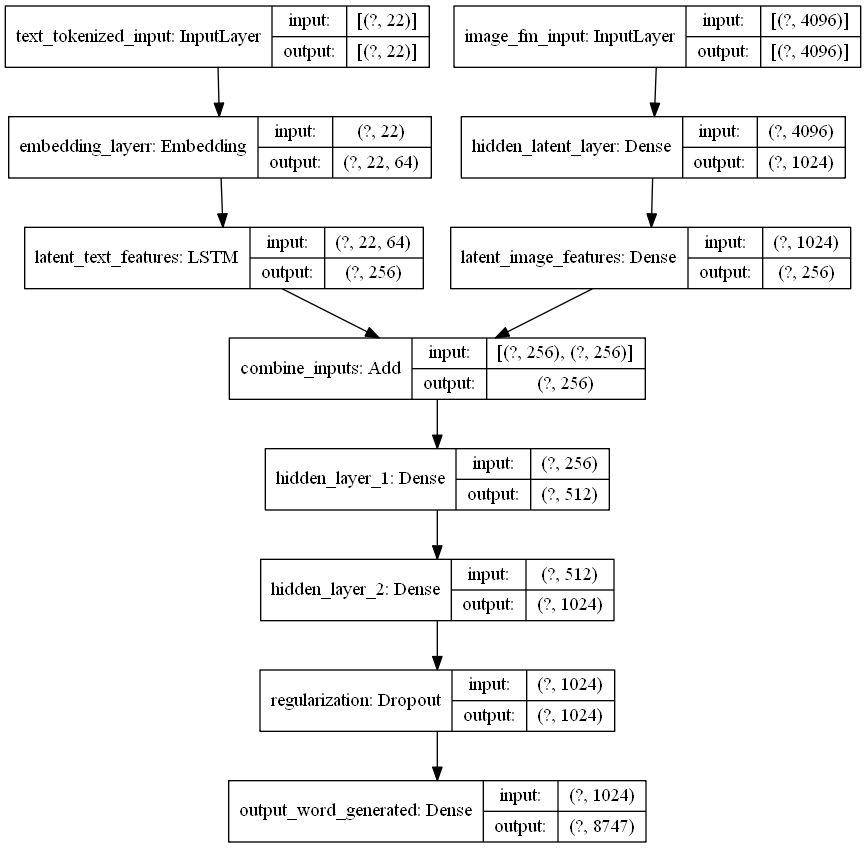

In [31]:
plot_model(total_model, show_shapes=True, to_file="model.png")

### Model training 

In [32]:
hist = total_model.fit([Ximage_train, Xtext_train], ytext_train, epochs=6, verbose=1, batch_size=128, validation_data=([Ximage_val, Xtext_val], ytext_val))
save_model(total_model, "model.h5")

Epoch 1/6
272/272 [==============================] - 78s 285ms/step - loss: 6.0821 - val_loss: 5.7010
Epoch 2/6
272/272 [==============================] - 80s 294ms/step - loss: 5.4746 - val_loss: 5.5522
Epoch 3/6
272/272 [==============================] - 83s 306ms/step - loss: 5.2700 - val_loss: 5.4537
Epoch 4/6
272/272 [==============================] - 88s 324ms/step - loss: 5.1025 - val_loss: 5.4404
Epoch 5/6
272/272 [==============================] - 89s 326ms/step - loss: 4.9521 - val_loss: 5.4009
Epoch 6/6
272/272 [==============================] - 89s 326ms/step - loss: 4.8066 - val_loss: 5.4454


### Model evaluation

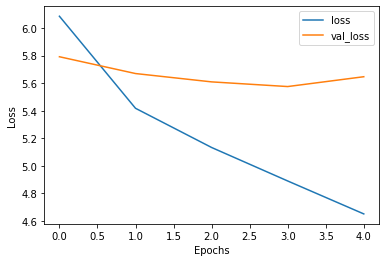

In [16]:
# FIRST OLD MODEL
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

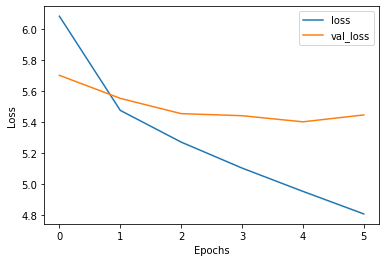

In [33]:
#Last model (model.h5)
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Model inference

In [49]:
# Loading model 
model = load_model('model.h5')

In [50]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
_ = [print(index_word[i]) for i in range(1,5)]

'startseq'
'endseq'
'dog'
'man'


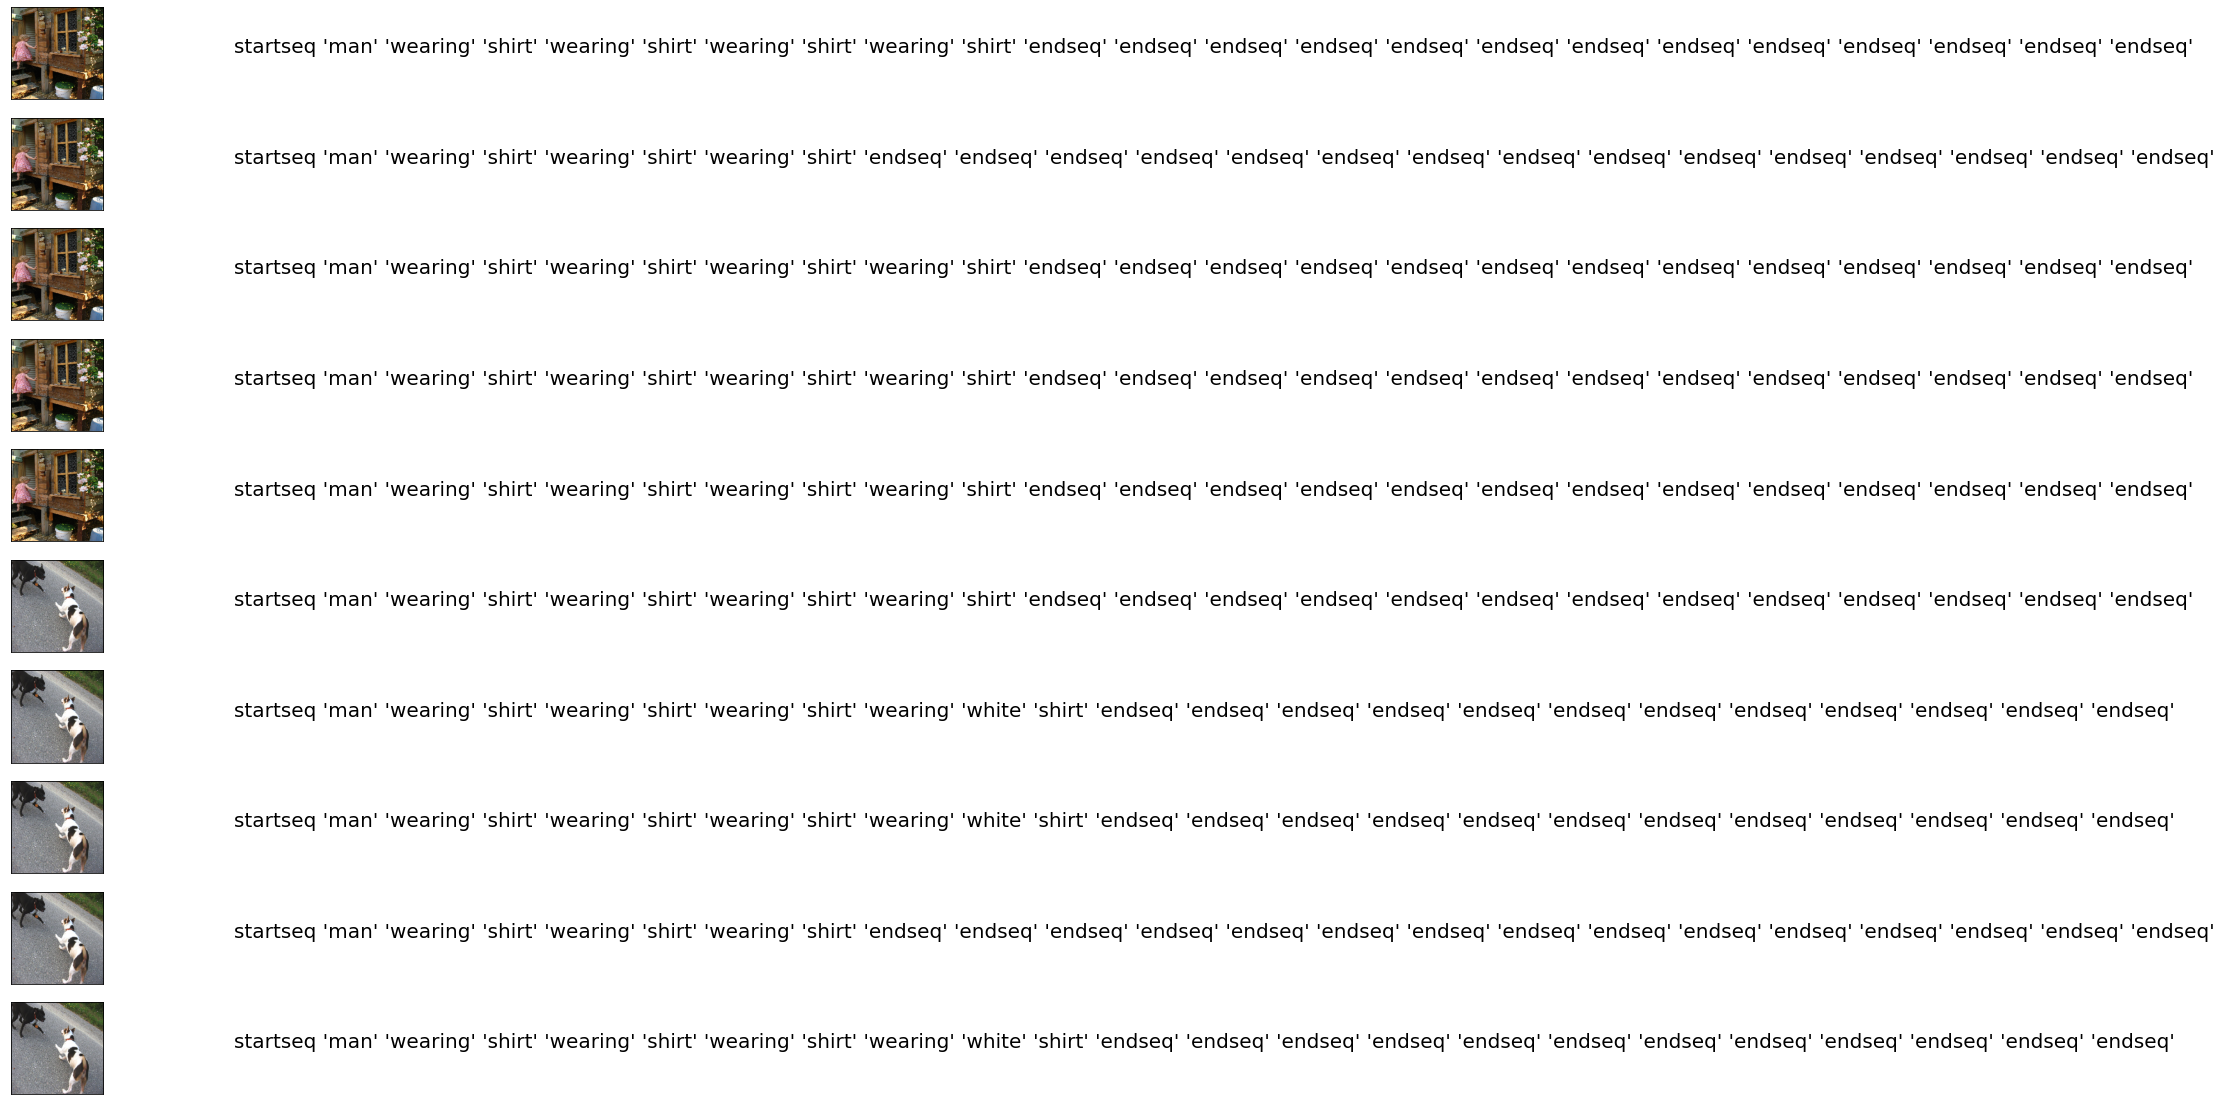

In [52]:
# Make predictions on image
def predict_caption(model, image, maxlen, tokenizer):
    in_text = 'startseq'
    index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 10
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dataset_image_path + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(model,image_feature.reshape(1,len(image_feature)), maxlen, tokenizer)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()